# Fiat Debasement & Wealth Allocation — Regression Analysis

This notebook quantifies the relationship between debasement conditions and asset return spreads over real USD cash.
The analysis proceeds in four stages: (1) PCA re-derivation to obtain PC1 and PC2 scores, (2) baseline OLS regressions
with Newey-West HAC standard errors for BTC, gold and S&P 500, (3) subsample stability check across pre/post-2020
structural break, and (4) rolling regression and regime analysis to characterize time-varying relationships.

## 0. Imports & Configuration

In [24]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

warnings.filterwarnings("ignore")

plt.rcParams.update({
    "figure.dpi":        130,
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "axes.grid":         True,
    "grid.alpha":        0.3,
    "font.size":         11,
})

PROCESSED_DATA_DIR = "processed_data"
FIGURES_DIR        = "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

# Structural break date separating pre/post QE regimes
STRUCTURAL_BREAK_DATE = "2020-03-01"

# Rolling regression window in months
ROLLING_WINDOW_MONTHS = 36

# Newey-West lag length — 12 months to cover seasonal autocorrelation
NEWEY_WEST_LAGS = 12

# Debasement indicator columns for PCA re-derivation
DEBASEMENT_INDICATOR_COLUMNS = [
    "m2_yoy_pct",
    "cpi_yoy_pct",
    "real_m2_growth",
    "m2_to_gdp",
]

# Asset spread columns and display labels
ASSET_SPREAD_CONFIGS = {
    "btc_vs_cash_real_spread":   {"label": "BTC",     "color": "#F7931A"},
    "gold_vs_cash_real_spread":  {"label": "Gold",    "color": "#C9A84C"},
    "sp500_vs_cash_real_spread": {"label": "S&P 500", "color": "#4C72B0"},
}

## 1. Load Data & Re-derive PCA Scores

In [25]:
analysis_df = pd.read_csv(
    os.path.join(PROCESSED_DATA_DIR, "analysis_df.csv"),
    index_col=0,
    parse_dates=True
)
analysis_df.index.name = "date"

print(f"Shape: {analysis_df.shape}")
print(f"Date range: {analysis_df.index.min().date()} → {analysis_df.index.max().date()}")

Shape: (119, 18)
Date range: 2015-09-30 → 2025-07-31


In [26]:
# Re-standardize debasement indicators and fit PCA — deterministic so results are identical to EDA notebook
scaler = StandardScaler()
debasement_matrix_standardized = scaler.fit_transform(analysis_df[DEBASEMENT_INDICATOR_COLUMNS])

pca_model = PCA(n_components=4)
pca_scores = pca_model.fit_transform(debasement_matrix_standardized)

# Store PC1 and PC2 as dataframe columns
analysis_df["pc1_debasement"] = pca_scores[:, 0]
analysis_df["pc2_debasement"] = pca_scores[:, 1]

# Orient PC1 so that higher values = more debasement pressure (align with z-score composite)
if analysis_df["pc1_debasement"].corr(analysis_df["zscore_composite_debasement_score"]) < 0:
    analysis_df["pc1_debasement"] = -analysis_df["pc1_debasement"]
    pca_model.components_[0] = -pca_model.components_[0]
    print("PC1 sign flipped to align with debasement direction")

explained_variance = pca_model.explained_variance_ratio_
print(f"\nPC1 variance explained: {explained_variance[0] * 100:.1f}%")
print(f"PC2 variance explained: {explained_variance[1] * 100:.1f}%")
print(f"Cumulative PC1+PC2:     {(explained_variance[0] + explained_variance[1]) * 100:.1f}%")

print(f"\nPC1 loadings:")
for indicator, loading in zip(DEBASEMENT_INDICATOR_COLUMNS, pca_model.components_[0]):
    print(f"  {indicator:30s}: {loading:+.4f}")

print(f"\nPC2 loadings:")
for indicator, loading in zip(DEBASEMENT_INDICATOR_COLUMNS, pca_model.components_[1]):
    print(f"  {indicator:30s}: {loading:+.4f}")


PC1 variance explained: 59.1%
PC2 variance explained: 38.5%
Cumulative PC1+PC2:     97.6%

PC1 loadings:
  m2_yoy_pct                    : +0.6456
  cpi_yoy_pct                   : -0.1259
  real_m2_growth                : +0.6226
  m2_to_gdp                     : +0.4239

PC2 loadings:
  m2_yoy_pct                    : -0.0133
  cpi_yoy_pct                   : +0.7772
  real_m2_growth                : -0.2282
  m2_to_gdp                     : +0.5863


## 2. Pre-Regression Diagnostics

Check autocorrelation and heteroskedasticity in the dependent variables to confirm Newey-West correction is warranted.

In [27]:
print("Durbin-Watson statistics (2.0 = no autocorrelation, <2 = positive autocorrelation):")
print()
for spread_column, config in ASSET_SPREAD_CONFIGS.items():
    dw_statistic = durbin_watson(analysis_df[spread_column].dropna())
    print(f"  {config['label']:8s}: DW = {dw_statistic:.4f}")

print()
print("Correlation between regressors (PC1, PC2, real_rate_10y):")
regressor_correlation = analysis_df[["pc1_debasement", "pc2_debasement", "tips_real_yield_10y"]].corr()
print(regressor_correlation.round(4).to_string())

Durbin-Watson statistics (2.0 = no autocorrelation, <2 = positive autocorrelation):

  BTC     : DW = 1.6341
  Gold    : DW = 1.8524
  S&P 500 : DW = 2.1668

Correlation between regressors (PC1, PC2, real_rate_10y):
                     pc1_debasement  pc2_debasement  tips_real_yield_10y
pc1_debasement               1.0000         -0.0000              -0.7934
pc2_debasement              -0.0000          1.0000              -0.0893
tips_real_yield_10y         -0.7934         -0.0893               1.0000


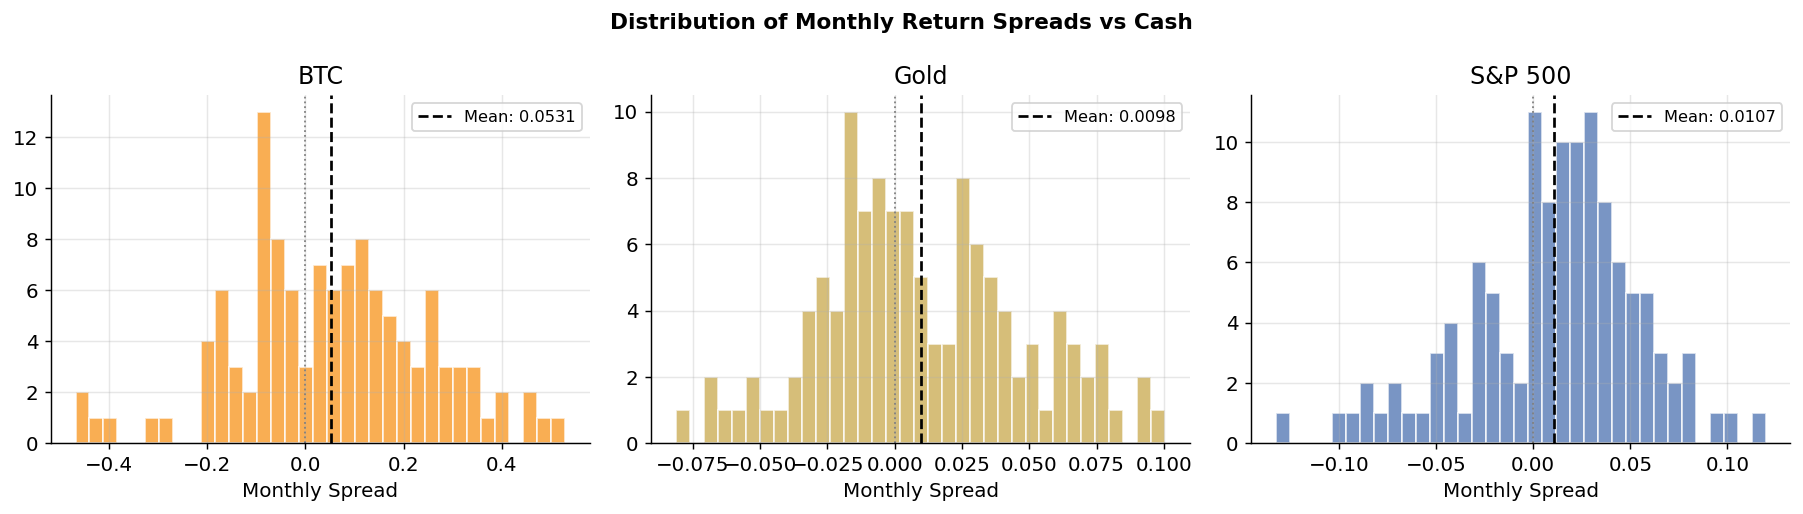

In [28]:
# Visual check of spread distributions — confirms heteroskedasticity for BTC
figure, axes = plt.subplots(1, 3, figsize=(14, 4))
figure.suptitle("Distribution of Monthly Return Spreads vs Cash", fontsize=12, fontweight="bold")

for axis, (spread_column, config) in zip(axes, ASSET_SPREAD_CONFIGS.items()):
    spread_values = analysis_df[spread_column].dropna()
    axis.hist(spread_values, bins=35, color=config["color"], alpha=0.75, edgecolor="white")
    axis.axvline(spread_values.mean(), color="black", linewidth=1.5, linestyle="--",
                 label=f"Mean: {spread_values.mean():.4f}")
    axis.axvline(0, color="grey", linewidth=1.0, linestyle=":")
    axis.set_title(config["label"])
    axis.set_xlabel("Monthly Spread")
    axis.legend(fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "spread_distributions.png"), bbox_inches="tight")
plt.show()

## 3. Baseline OLS Regressions — Full Sample

Model: `spread ~ PC1 + PC2 + real_rate_10y` with Newey-West HAC standard errors (12 lags).

In [29]:
def run_ols_with_newey_west(dependent_variable: pd.Series,
                             regressors_df: pd.DataFrame,
                             n_lags: int) -> sm.regression.linear_model.RegressionResultsWrapper:
    """
    Fits OLS regression with Newey-West HAC standard errors to correct for autocorrelation
    and heteroskedasticity in monthly financial return data.

    Args:
        dependent_variable: Monthly spread series as dependent variable
        regressors_df: DataFrame of regressor columns (without constant)
        n_lags: Number of lags for Newey-West covariance estimator

    Returns:
        Fitted statsmodels RegressionResults with Newey-West covariance applied
    """
    regressors_with_constant = sm.add_constant(regressors_df)

    aligned_data = pd.concat([dependent_variable, regressors_with_constant], axis=1).dropna()
    y = aligned_data.iloc[:, 0]
    X = aligned_data.iloc[:, 1:]

    # Single-step HAC fit preserves named pandas Series on all result attributes
    hac_result = sm.OLS(y, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": n_lags},
        use_t=True
    )

    return hac_result


# Build regressor matrix — PC1, PC2, real rates
regressors_full_sample = analysis_df[["pc1_debasement", "pc2_debasement", "tips_real_yield_10y"]]

# Run regression for each asset spread
full_sample_results = {}
for spread_column, config in ASSET_SPREAD_CONFIGS.items():
    result = run_ols_with_newey_west(
        dependent_variable=analysis_df[spread_column],
        regressors_df=regressors_full_sample,
        n_lags=NEWEY_WEST_LAGS
    )
    full_sample_results[config["label"]] = result
    print(f"{'='*60}")
    print(f"FULL SAMPLE — {config['label']} vs Cash Spread")
    print(f"{'='*60}")
    print(result.summary2())
    print()

FULL SAMPLE — BTC vs Cash Spread
                    Results: Ordinary least squares
Model:              OLS                     Adj. R-squared:     0.047   
Dependent Variable: btc_vs_cash_real_spread AIC:                -49.0054
Date:               2026-02-17 21:11        BIC:                -37.8889
No. Observations:   119                     Log-Likelihood:     28.503  
Df Model:           3                       F-statistic:        6.044   
Df Residuals:       115                     Prob (F-statistic): 0.000738
R-squared:          0.071                   Scale:              0.037526
-------------------------------------------------------------------------
                      Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------------
const                 0.0448    0.0247   1.8153  0.0721  -0.0041   0.0937
pc1_debasement        0.0249    0.0148   1.6898  0.0938  -0.0043   0.0542
pc2_debasement       -0.0348    0.

In [31]:
# Compact coefficient comparison table across all three assets
coefficient_rows = []
for asset_label, result in full_sample_results.items():
    for regressor_name in ["pc1_debasement", "pc2_debasement", "tips_real_yield_10y"]:
        
        # Safely retrieve by name from the Series index
        coef    = result.params.get(regressor_name, result.params[regressor_name])
        std_err = result.bse[regressor_name]
        t_stat  = result.tvalues[regressor_name]
        p_value = result.pvalues[regressor_name]
        
        coefficient_rows.append({
            "asset":       asset_label,
            "regressor":   regressor_name,
            "coef":        coef,
            "std_err":     std_err,
            "t_stat":      t_stat,
            "p_value":     p_value,
            "significant": p_value < 0.05,
            "r_squared":   result.rsquared,
        })

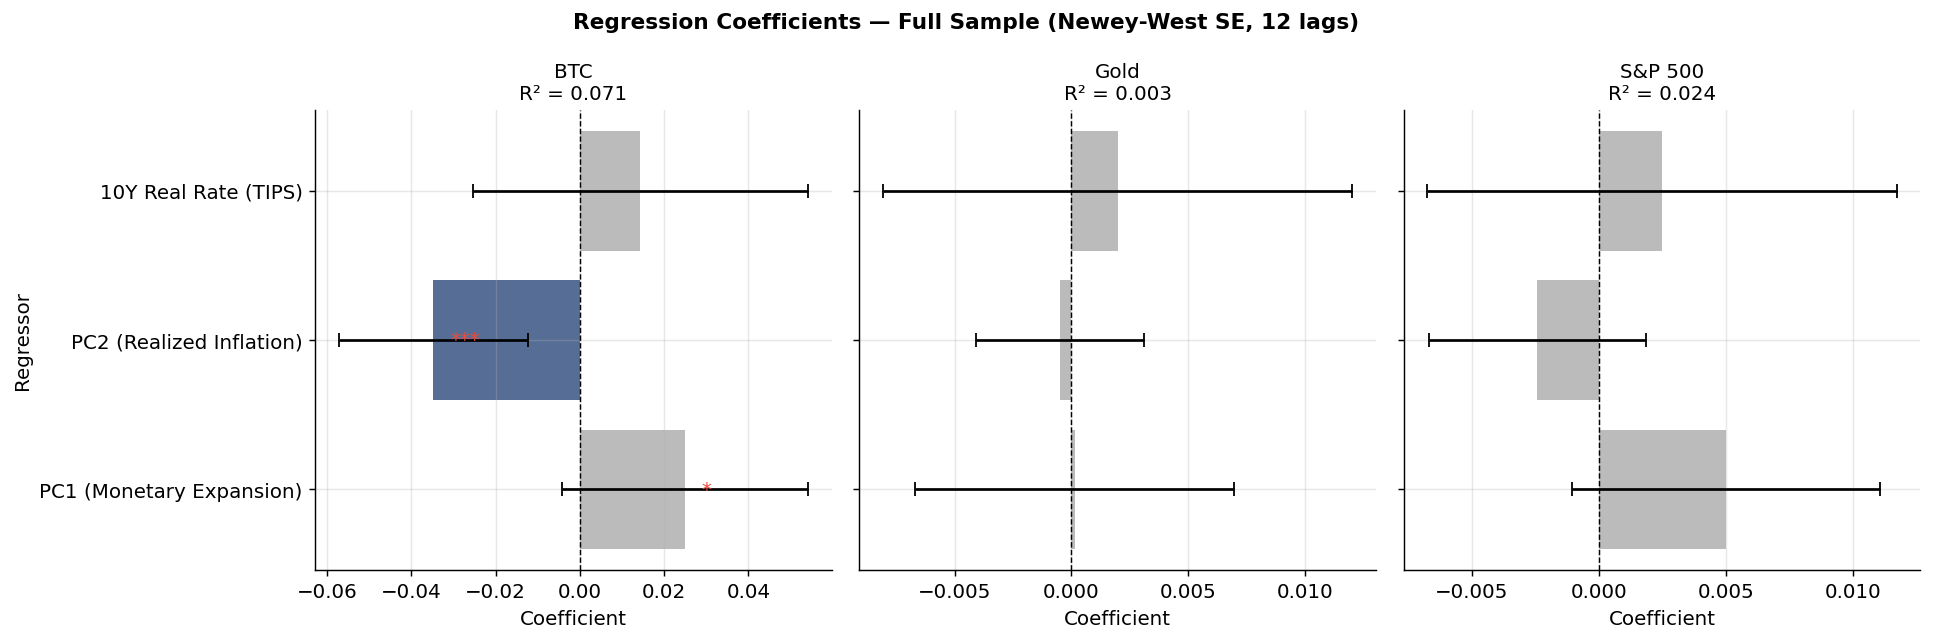

In [32]:
# Coefficient plot with confidence intervals
regressor_labels = {
    "pc1_debasement":      "PC1 (Monetary Expansion)",
    "pc2_debasement":      "PC2 (Realized Inflation)",
    "tips_real_yield_10y": "10Y Real Rate (TIPS)",
}

figure, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
figure.suptitle("Regression Coefficients — Full Sample (Newey-West SE, 12 lags)",
                fontsize=12, fontweight="bold")

for axis, (asset_label, result) in zip(axes, full_sample_results.items()):
    regressors_to_plot = list(regressor_labels.keys())
    coefficients       = [result.params[reg] for reg in regressors_to_plot]
    confidence_intervals = result.conf_int().loc[regressors_to_plot]
    errors_lower       = [coef - ci[0] for coef, ci in zip(coefficients, confidence_intervals.values)]
    errors_upper       = [ci[1] - coef for coef, ci in zip(coefficients, confidence_intervals.values)]
    p_values           = [result.pvalues[reg] for reg in regressors_to_plot]

    # Color bars by significance
    bar_colors = ["#2C4A7C" if p < 0.05 else "#AAAAAA" for p in p_values]
    display_labels = [regressor_labels[reg] for reg in regressors_to_plot]

    bars = axis.barh(display_labels, coefficients, xerr=[errors_lower, errors_upper],
                     color=bar_colors, alpha=0.8, capsize=4, error_kw={"linewidth": 1.5})
    axis.axvline(0, color="black", linewidth=0.8, linestyle="--")
    axis.set_title(f"{asset_label}\nR² = {result.rsquared:.3f}", fontsize=11)
    axis.set_xlabel("Coefficient")

    # Annotate p-values
    for bar, p_value in zip(bars, p_values):
        significance_label = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.10 else ""
        if significance_label:
            axis.text(
                bar.get_width() + max(errors_upper) * 0.1,
                bar.get_y() + bar.get_height() / 2,
                significance_label,
                va="center", fontsize=11, color="#E74C3C"
            )

axes[0].set_ylabel("Regressor")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "regression_coefficients_full_sample.png"), bbox_inches="tight")
plt.show()

## 4. Subsample Stability — Pre vs Post 2020 Structural Break

In [33]:
pre_2020_df  = analysis_df[analysis_df.index < STRUCTURAL_BREAK_DATE]
post_2020_df = analysis_df[analysis_df.index >= STRUCTURAL_BREAK_DATE]

print(f"Pre-2020 sample:  {len(pre_2020_df)} months ({pre_2020_df.index.min().date()} → {pre_2020_df.index.max().date()})")
print(f"Post-2020 sample: {len(post_2020_df)} months ({post_2020_df.index.min().date()} → {post_2020_df.index.max().date()})")

Pre-2020 sample:  54 months (2015-09-30 → 2020-02-29)
Post-2020 sample: 65 months (2020-03-31 → 2025-07-31)


In [34]:
subsample_results = {"pre_2020": {}, "post_2020": {}}

for subsample_label, subsample_df in [("pre_2020", pre_2020_df), ("post_2020", post_2020_df)]:
    regressors_subsample = subsample_df[["pc1_debasement", "pc2_debasement", "tips_real_yield_10y"]]

    for spread_column, config in ASSET_SPREAD_CONFIGS.items():
        result = run_ols_with_newey_west(
            dependent_variable=subsample_df[spread_column],
            regressors_df=regressors_subsample,
            n_lags=6   # Shorter lag for smaller subsamples
        )
        subsample_results[subsample_label][config["label"]] = result

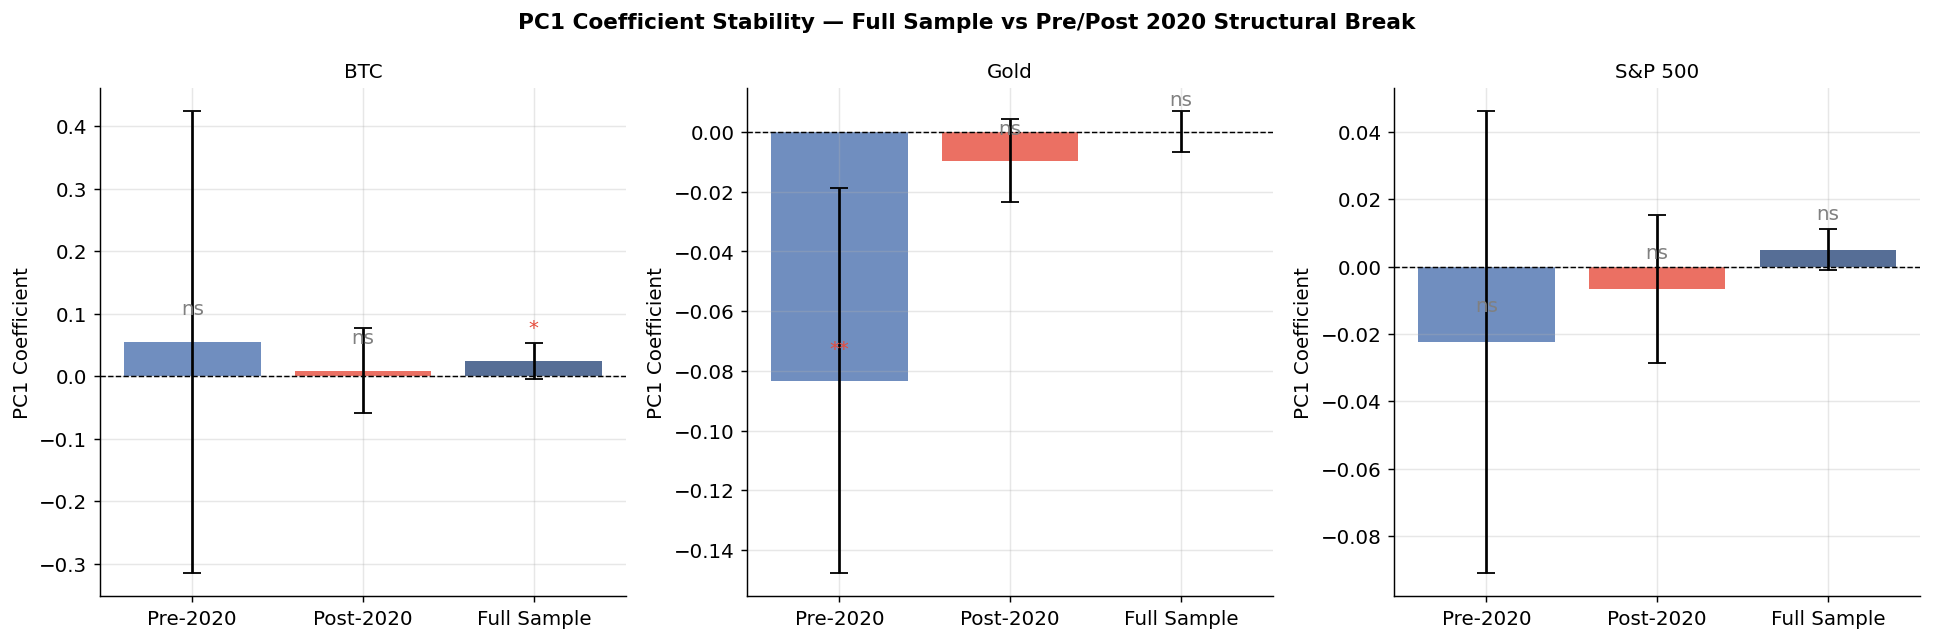

R² by subsample and asset:
Asset          Pre-2020    Post-2020  Full Sample
BTC              0.0354       0.1360       0.0713
Gold             0.1318       0.0442       0.0026
S&P 500          0.0209       0.0577       0.0236


In [35]:
# Subsample coefficient comparison — PC1 coefficient across pre/post/full for each asset
figure, axes = plt.subplots(1, 3, figsize=(15, 5))
figure.suptitle("PC1 Coefficient Stability — Full Sample vs Pre/Post 2020 Structural Break",
                fontsize=12, fontweight="bold")

subsample_display_labels = ["Pre-2020", "Post-2020", "Full Sample"]
subsample_colors         = ["#4C72B0", "#E74C3C", "#2C4A7C"]

for axis, (asset_label, config) in zip(axes, ASSET_SPREAD_CONFIGS.items()):
    asset_display_label = config["label"]

    pc1_coefficients = [
        subsample_results["pre_2020"][asset_display_label].params["pc1_debasement"],
        subsample_results["post_2020"][asset_display_label].params["pc1_debasement"],
        full_sample_results[asset_display_label].params["pc1_debasement"],
    ]
    pc1_conf_intervals = [
        subsample_results["pre_2020"][asset_display_label].conf_int().loc["pc1_debasement"],
        subsample_results["post_2020"][asset_display_label].conf_int().loc["pc1_debasement"],
        full_sample_results[asset_display_label].conf_int().loc["pc1_debasement"],
    ]

    errors_lower = [coef - ci[0] for coef, ci in zip(pc1_coefficients, pc1_conf_intervals)]
    errors_upper = [ci[1] - coef for coef, ci in zip(pc1_coefficients, pc1_conf_intervals)]

    bars = axis.bar(
        subsample_display_labels,
        pc1_coefficients,
        yerr=[errors_lower, errors_upper],
        color=subsample_colors,
        alpha=0.8,
        capsize=5,
        error_kw={"linewidth": 1.5}
    )
    axis.axhline(0, color="black", linewidth=0.8, linestyle="--")
    axis.set_title(asset_display_label, fontsize=11)
    axis.set_ylabel("PC1 Coefficient")

    # Annotate significance
    p_values = [
        subsample_results["pre_2020"][asset_display_label].pvalues["pc1_debasement"],
        subsample_results["post_2020"][asset_display_label].pvalues["pc1_debasement"],
        full_sample_results[asset_display_label].pvalues["pc1_debasement"],
    ]
    for bar, p_value in zip(bars, p_values):
        significance_label = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.10 else "ns"
        axis.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(errors_upper) * 0.1 + 0.001,
            significance_label,
            ha="center", va="bottom", fontsize=11,
            color="#E74C3C" if significance_label != "ns" else "grey"
        )

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "pc1_coefficient_subsample_stability.png"), bbox_inches="tight")
plt.show()

# Print R² by subsample
print("R² by subsample and asset:")
print(f"{'Asset':10s} {'Pre-2020':>12s} {'Post-2020':>12s} {'Full Sample':>12s}")
for asset_label in [config["label"] for config in ASSET_SPREAD_CONFIGS.values()]:
    r2_pre  = subsample_results["pre_2020"][asset_label].rsquared
    r2_post = subsample_results["post_2020"][asset_label].rsquared
    r2_full = full_sample_results[asset_label].rsquared
    print(f"{asset_label:10s} {r2_pre:>12.4f} {r2_post:>12.4f} {r2_full:>12.4f}")

## 5. Rolling Regression — Time-Varying PC1 Coefficient

36-month rolling window OLS to show how the debasement-to-spread relationship evolves through time.

In [36]:
def compute_rolling_pc1_coefficient(spread_series: pd.Series,
                                     pc1_series: pd.Series,
                                     window: int) -> pd.DataFrame:
    """
    Computes rolling OLS coefficient, standard error and p-value for PC1 against a spread series
    using a fixed-width rolling window, returning results aligned to the window end date.

    Args:
        spread_series: Monthly asset spread series as dependent variable
        pc1_series: PC1 debasement score series as single regressor
        window: Rolling window size in months

    Returns:
        DataFrame with columns [coef, std_err, p_value, r_squared] indexed by window end date
    """
    combined_data = pd.concat([spread_series, pc1_series], axis=1).dropna()
    combined_data.columns = ["spread", "pc1"]

    rolling_records = []

    for window_end_position in range(window, len(combined_data) + 1):
        window_data = combined_data.iloc[window_end_position - window: window_end_position]
        window_end_date = window_data.index[-1]

        X_window = sm.add_constant(window_data["pc1"])
        y_window = window_data["spread"]

        try:
            window_result = sm.OLS(y_window, X_window).fit()
            rolling_records.append({
                "date":      window_end_date,
                "coef":      window_result.params["pc1"],
                "std_err":   window_result.bse["pc1"],
                "p_value":   window_result.pvalues["pc1"],
                "r_squared": window_result.rsquared,
            })
        except Exception:
            pass

    return pd.DataFrame(rolling_records).set_index("date")


# Compute rolling coefficients for all three assets
rolling_coefficient_results = {}
for spread_column, config in ASSET_SPREAD_CONFIGS.items():
    rolling_coefficient_results[config["label"]] = compute_rolling_pc1_coefficient(
        spread_series=analysis_df[spread_column],
        pc1_series=analysis_df["pc1_debasement"],
        window=ROLLING_WINDOW_MONTHS
    )

print(f"Rolling regression computed — window: {ROLLING_WINDOW_MONTHS} months")

Rolling regression computed — window: 36 months


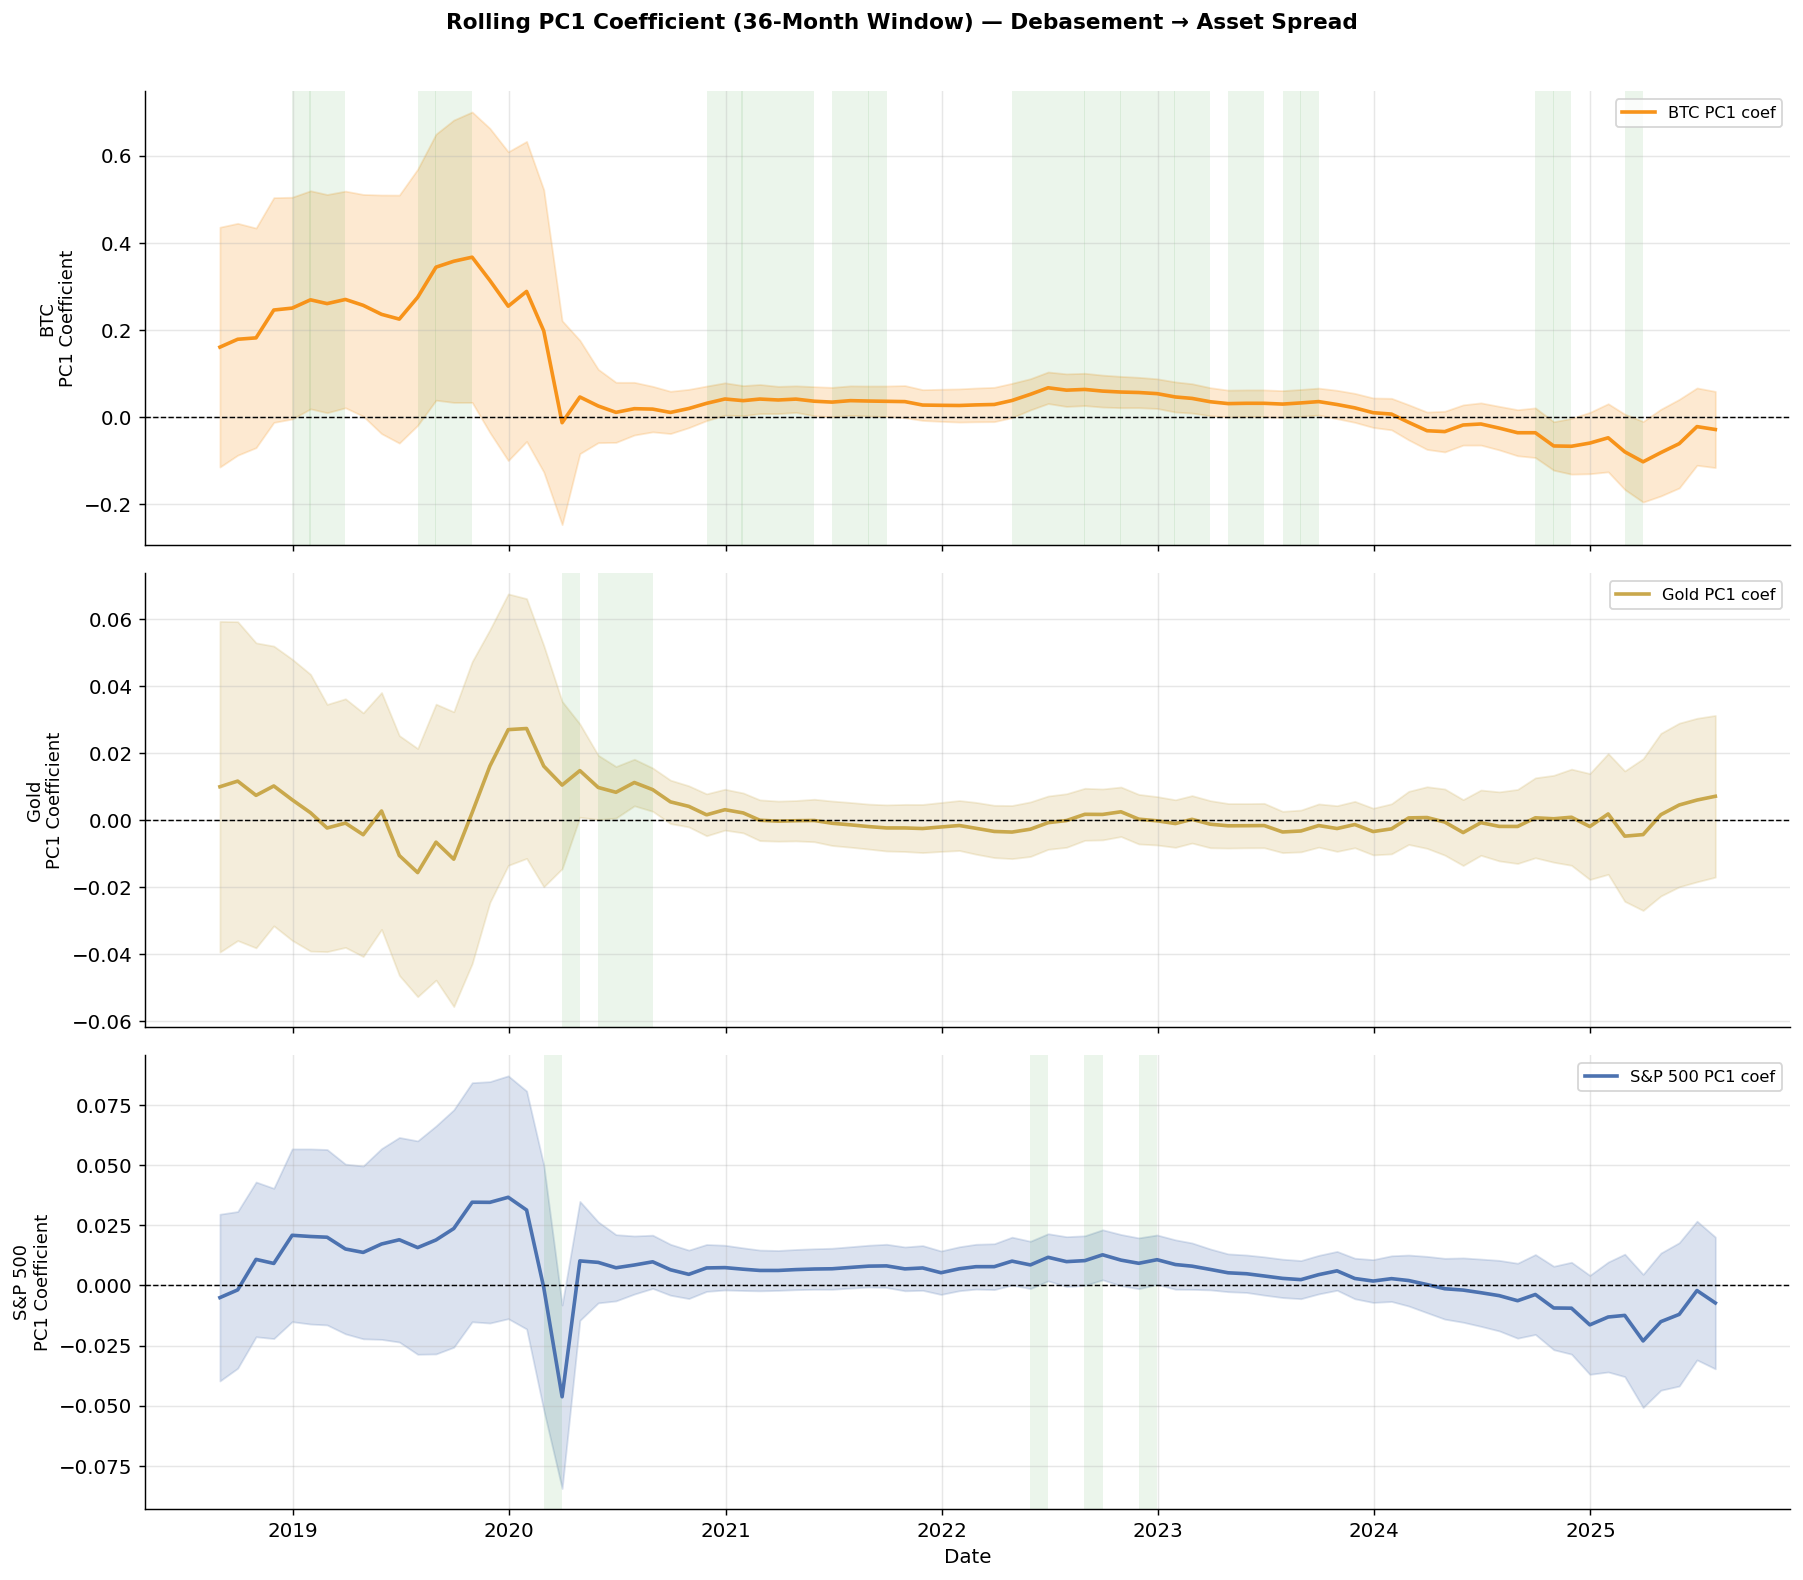

In [37]:
# Plot rolling PC1 coefficient over time for each asset
figure, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
figure.suptitle(
    f"Rolling PC1 Coefficient ({ROLLING_WINDOW_MONTHS}-Month Window) — Debasement → Asset Spread",
    fontsize=12, fontweight="bold", y=1.01
)

for axis, (spread_column, config) in zip(axes, ASSET_SPREAD_CONFIGS.items()):
    asset_label    = config["label"]
    rolling_result = rolling_coefficient_results[asset_label]

    # Confidence band: coefficient ± 1.96 * std_err
    coefficient_upper = rolling_result["coef"] + 1.96 * rolling_result["std_err"]
    coefficient_lower = rolling_result["coef"] - 1.96 * rolling_result["std_err"]

    axis.fill_between(rolling_result.index, coefficient_lower, coefficient_upper,
                      alpha=0.2, color=config["color"])
    axis.plot(rolling_result.index, rolling_result["coef"],
              color=config["color"], linewidth=2, label=f"{asset_label} PC1 coef")
    axis.axhline(0, color="black", linewidth=0.8, linestyle="--")

    # Shade significant periods
    significant_periods = rolling_result[rolling_result["p_value"] < 0.05]
    for sig_date in significant_periods.index:
        axis.axvspan(sig_date - pd.DateOffset(months=1), sig_date,
                     alpha=0.08, color="green", linewidth=0)

    axis.set_ylabel(f"{asset_label}\nPC1 Coefficient", fontsize=10)
    axis.legend(fontsize=9)
    axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "rolling_pc1_coefficient.png"), bbox_inches="tight")
plt.show()

## 6. Regime Analysis — High vs Low Debasement

Split months by PC1 above/below median and compare mean spreads across regimes with t-tests.

In [38]:
# Define high/low debasement regimes by PC1 median split
pc1_median = analysis_df["pc1_debasement"].median()
analysis_df["debasement_regime"] = np.where(
    analysis_df["pc1_debasement"] >= pc1_median,
    "High Debasement",
    "Low Debasement"
)

high_debasement_df = analysis_df[analysis_df["debasement_regime"] == "High Debasement"]
low_debasement_df  = analysis_df[analysis_df["debasement_regime"] == "Low Debasement"]

print(f"PC1 median split: {pc1_median:.4f}")
print(f"High debasement months: {len(high_debasement_df)}")
print(f"Low debasement months:  {len(low_debasement_df)}")

PC1 median split: -0.4092
High debasement months: 60
Low debasement months:  59


In [39]:
# T-test for each asset spread: high vs low debasement regime
print("Regime Analysis — Mean Spread Comparison (High vs Low Debasement)")
print(f"{'Asset':10s} {'Mean (High)':>14s} {'Mean (Low)':>12s} {'Difference':>12s} {'t-stat':>10s} {'p-value':>10s} {'Significant':>12s}")
print("-" * 82)

regime_summary_records = []

for spread_column, config in ASSET_SPREAD_CONFIGS.items():
    high_regime_values = high_debasement_df[spread_column].dropna()
    low_regime_values  = low_debasement_df[spread_column].dropna()

    t_statistic, p_value = stats.ttest_ind(high_regime_values, low_regime_values, equal_var=False)

    mean_high      = high_regime_values.mean()
    mean_low       = low_regime_values.mean()
    mean_diff      = mean_high - mean_low
    is_significant = p_value < 0.05

    print(
        f"{config['label']:10s} {mean_high:>14.6f} {mean_low:>12.6f} "
        f"{mean_diff:>12.6f} {t_statistic:>10.4f} {p_value:>10.4f} "
        f"{'Yes ***' if p_value < 0.01 else 'Yes **' if p_value < 0.05 else 'No':>12s}"
    )

    regime_summary_records.append({
        "asset":       config["label"],
        "mean_high":   mean_high,
        "mean_low":    mean_low,
        "difference":  mean_diff,
        "t_stat":      t_statistic,
        "p_value":     p_value,
        "significant": is_significant,
    })

Regime Analysis — Mean Spread Comparison (High vs Low Debasement)
Asset         Mean (High)   Mean (Low)   Difference     t-stat    p-value  Significant
----------------------------------------------------------------------------------
BTC              0.076561     0.029289     0.047272     1.3030     0.1952           No
Gold             0.007975     0.011703    -0.003729    -0.5329     0.5951           No
S&P 500          0.011712     0.009588     0.002125     0.2612     0.7944           No


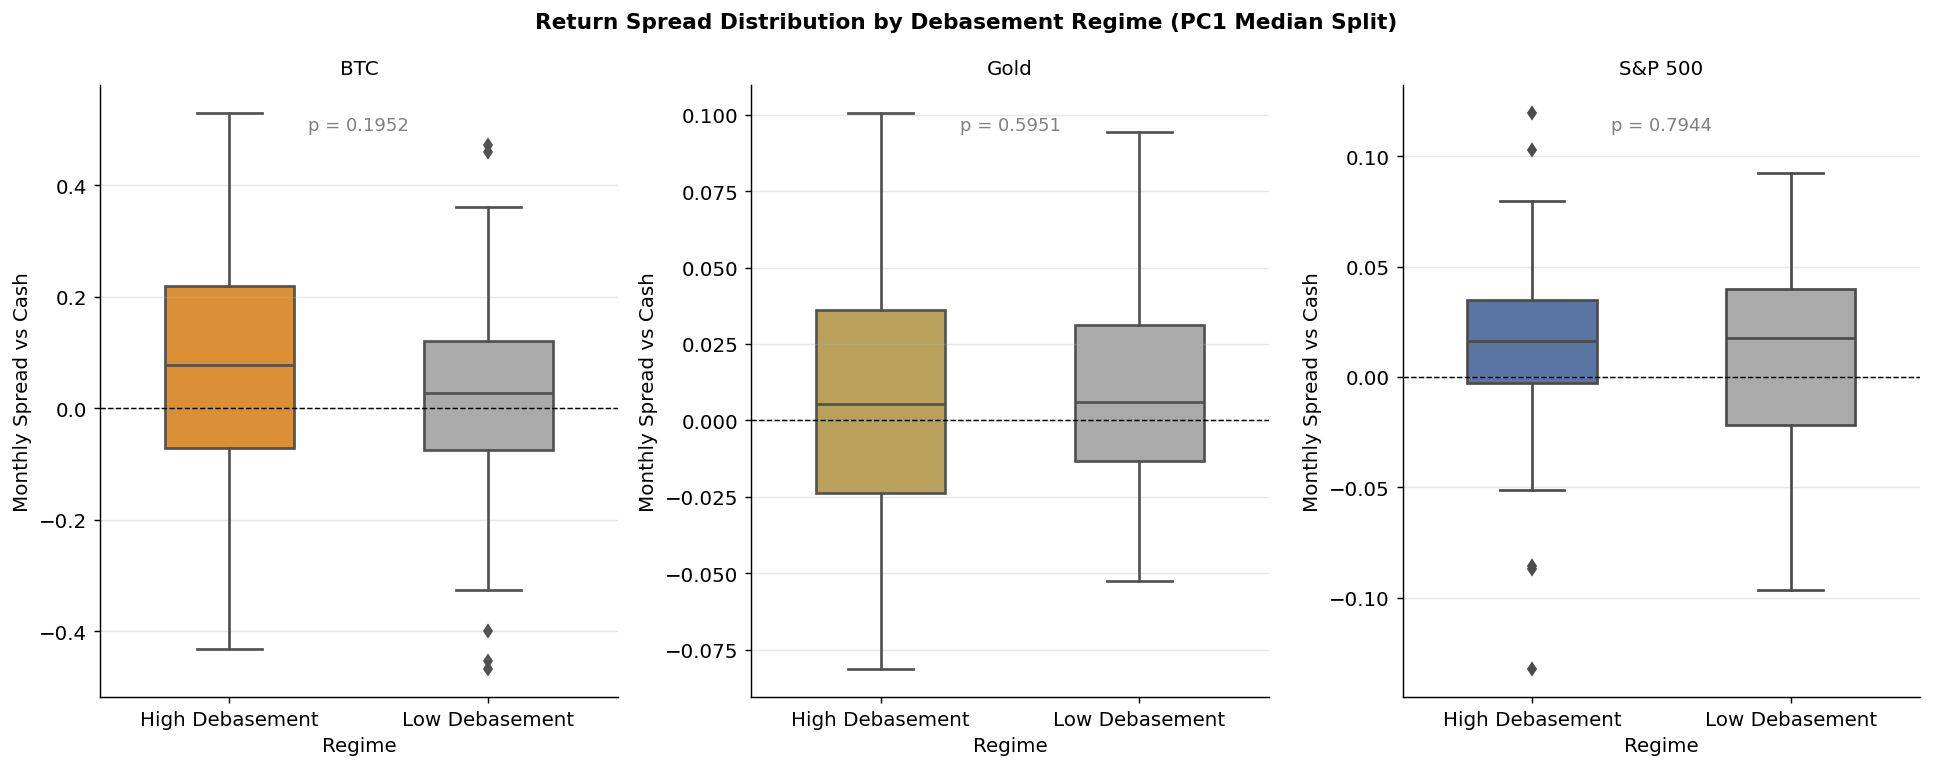

In [40]:
# Boxplot comparison of spread distributions by regime
figure, axes = plt.subplots(1, 3, figsize=(15, 6))
figure.suptitle("Return Spread Distribution by Debasement Regime (PC1 Median Split)",
                fontsize=12, fontweight="bold")

for axis, (spread_column, config) in zip(axes, ASSET_SPREAD_CONFIGS.items()):
    asset_label = config["label"]

    regime_plot_data = analysis_df[[spread_column, "debasement_regime"]].dropna()

    sns.boxplot(
        data=regime_plot_data,
        x="debasement_regime",
        y=spread_column,
        palette={"High Debasement": config["color"], "Low Debasement": "#AAAAAA"},
        width=0.5,
        ax=axis
    )
    axis.axhline(0, color="black", linewidth=0.8, linestyle="--")
    axis.set_title(asset_label, fontsize=11)
    axis.set_xlabel("Regime")
    axis.set_ylabel("Monthly Spread vs Cash")

    # Add p-value annotation
    regime_record = next(r for r in regime_summary_records if r["asset"] == asset_label)
    p_annotation  = f"p = {regime_record['p_value']:.4f}"
    axis.text(0.5, 0.95, p_annotation, transform=axis.transAxes,
              ha="center", va="top", fontsize=10,
              color="#E74C3C" if regime_record["significant"] else "grey")

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "regime_spread_boxplots.png"), bbox_inches="tight")
plt.show()

## 7. Summary of Findings

In [41]:
print("=" * 70)
print("REGRESSION ANALYSIS — SUMMARY OF FINDINGS")
print("=" * 70)

print("\n1. FULL SAMPLE BASELINE REGRESSION")
for asset_label, result in full_sample_results.items():
    pc1_coef    = result.params["pc1_debasement"]
    pc1_pvalue  = result.pvalues["pc1_debasement"]
    pc2_coef    = result.params["pc2_debasement"]
    pc2_pvalue  = result.pvalues["pc2_debasement"]
    tips_coef   = result.params["tips_real_yield_10y"]
    tips_pvalue = result.pvalues["tips_real_yield_10y"]
    r2          = result.rsquared
    print(f"\n  {asset_label}:")
    print(f"    PC1 coef = {pc1_coef:+.4f}  (p={pc1_pvalue:.4f}) {'✓ significant' if pc1_pvalue < 0.05 else '✗ not significant'}")
    print(f"    PC2 coef = {pc2_coef:+.4f}  (p={pc2_pvalue:.4f}) {'✓ significant' if pc2_pvalue < 0.05 else '✗ not significant'}")
    print(f"    TIPS coef= {tips_coef:+.4f}  (p={tips_pvalue:.4f}) {'✓ significant' if tips_pvalue < 0.05 else '✗ not significant'}")
    print(f"    R² = {r2:.4f}")

print("\n2. SUBSAMPLE STABILITY (PC1 coefficient)")
for asset_label in [config["label"] for config in ASSET_SPREAD_CONFIGS.values()]:
    pre_coef  = subsample_results["pre_2020"][asset_label].params["pc1_debasement"]
    post_coef = subsample_results["post_2020"][asset_label].params["pc1_debasement"]
    full_coef = full_sample_results[asset_label].params["pc1_debasement"]
    print(f"  {asset_label}: pre={pre_coef:+.4f}  post={post_coef:+.4f}  full={full_coef:+.4f}")

print("\n3. REGIME ANALYSIS (High vs Low Debasement mean spread difference)")
for record in regime_summary_records:
    print(
        f"  {record['asset']:8s}: diff = {record['difference']:+.6f}  "
        f"(p={record['p_value']:.4f}) {'✓ significant' if record['significant'] else '✗ not significant'}"
    )

REGRESSION ANALYSIS — SUMMARY OF FINDINGS

1. FULL SAMPLE BASELINE REGRESSION

  BTC:
    PC1 coef = +0.0249  (p=0.0938) ✗ not significant
    PC2 coef = -0.0348  (p=0.0027) ✓ significant
    TIPS coef= +0.0143  (p=0.4763) ✗ not significant
    R² = 0.0713

  Gold:
    PC1 coef = +0.0001  (p=0.9670) ✗ not significant
    PC2 coef = -0.0005  (p=0.7947) ✗ not significant
    TIPS coef= +0.0020  (p=0.6968) ✗ not significant
    R² = 0.0026

  S&P 500:
    PC1 coef = +0.0050  (p=0.1049) ✗ not significant
    PC2 coef = -0.0024  (p=0.2619) ✗ not significant
    TIPS coef= +0.0025  (p=0.5962) ✗ not significant
    R² = 0.0236

2. SUBSAMPLE STABILITY (PC1 coefficient)
  BTC: pre=+0.0546  post=+0.0088  full=+0.0249
  Gold: pre=-0.0833  post=-0.0095  full=+0.0001
  S&P 500: pre=-0.0225  post=-0.0066  full=+0.0050

3. REGIME ANALYSIS (High vs Low Debasement mean spread difference)
  BTC     : diff = +0.047272  (p=0.1952) ✗ not significant
  Gold    : diff = -0.003729  (p=0.5951) ✗ not significan